In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
import numpy

In [37]:
from functools import partial

Uncertainty
========

Let's start by defining a FOPDT function as in the textbook

In [38]:
def G_P(k, theta, tau, s):
    """ Equation 7.19 """
    return k/(tau*s + 1)*numpy.exp(-theta*s)

Let's see what this looks like for particular values of $k$, $\tau$ and $\theta$

In [39]:
omega = numpy.logspace(-2, 2, 1000)
s = 1j*omega

In [40]:
Gnom = partial(G_P, 2.5, 2.5, 2.5)

In [41]:
def Gnom(s):
    return G_P(2.5, 2.5, 2.5, s)

In [42]:
Gfr = Gnom(s)

In [43]:
pomega = 0.5

In [44]:
def nominal_curve():
    plt.plot(Gfr.real, Gfr.imag)
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')

In [45]:
def nominal_point(pomega):
    Gnomp = Gnom(1j*pomega)
    plt.scatter(Gnomp.real, Gnomp.imag, s=100, color='magenta')

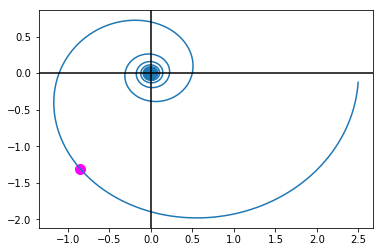

In [46]:
nominal_curve()
nominal_point(pomega)

At a particular frequency, let's look at a couple of possible plants

In [53]:
varrange = numpy.arange(2, 3, 0.1)
def cloudpoints(pomega):
    points = numpy.array([G_P(k, theta, tau, pomega*1j) 
                          for k in varrange 
                          for tau in varrange 
                          for theta in varrange])
    nominal_curve()
    nominal_point(pomega)
    plt.scatter(points.real, points.imag, color='red', alpha=0.1)

In [54]:
from ipywidgets import interact
import ipywidgets as widgets

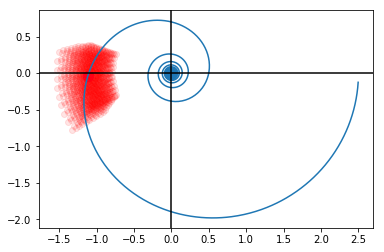

In [55]:
interact(cloudpoints, pomega=(0.1, 10))

Let's try to approximate this region by a disc

In [56]:
Gnomp = Gnom(1j*pomega)
points = numpy.array([G_P(k, theta, tau, pomega*1j) 
                      for k in varrange 
                      for tau in varrange 
                      for theta in varrange])

radius = max(abs(P - Gnomp) for P in points)
radius

0.80688459524668865

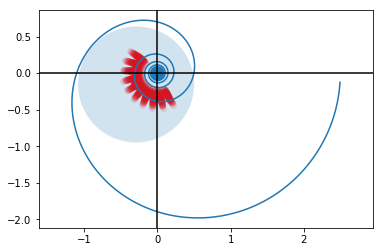

In [57]:
def discapprox(pomega, radius):
    Gnomp = Gnom(1j*pomega)
    c = plt.Circle((Gnomp.real, Gnomp.imag), radius, alpha=0.2)
    cloudpoints(pomega)
    plt.gca().add_artist(c)
    plt.axis('equal')
interact(discapprox, pomega=(0.1, 5), radius=radius)

The above represents an _additive_ uncertainty description, 
$$ |\Delta_A| < 1 $$
$$ G_p(s) = G(s) + w_A(s)\Delta_A(s); \quad |\Delta_A(j\omega) | \leq 1 \forall \omega| (7.20)$$

In [58]:
Npoints = 10000
Delta_As = (numpy.random.rand(Npoints)*2-1 + 
            (numpy.random.rand(Npoints)*2 - 1)*1j)
valid_values = numpy.abs(Delta_As) < 1
Delta_As = Delta_As[valid_values]

(-1.1033047016805937,
 1.1077827839146033,
 -1.1142542781405189,
 1.1095002370300728)

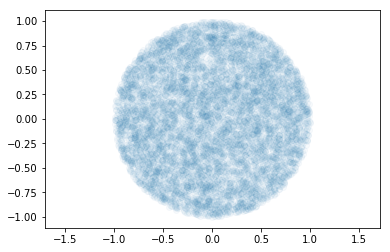

In [19]:
plt.scatter(Delta_As.real, Delta_As.imag, alpha=0.03)
plt.axis('equal')

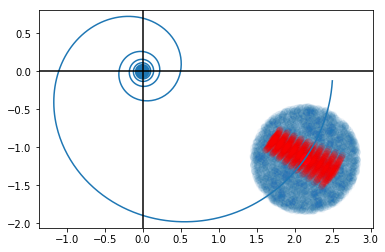

In [59]:
def discapprox(pomega, radius):
    Gnomp = Gnom(1j*pomega)
    #c = plt.Circle((Gnomp.real, Gnomp.imag), radius, alpha=0.2)
    Gp_A = Gnomp + radius*Delta_As
    plt.scatter(Gp_A.real, Gp_A.imag, alpha=0.03)
    cloudpoints(pomega)
    #plt.gca().add_artist(c)
    plt.axis('equal')
interact(discapprox, pomega=(0.1, 5), radius=radius)

We now build frequency response for $\Pi$ (all possible plants).

In [60]:
Pi = numpy.array([G_P(k, theta, tau, s) 
                  for k in varrange 
                  for tau in varrange 
                  for theta in varrange])

In [61]:
deviations = numpy.abs(Pi - Gfr)

In [62]:
maxima = numpy.max(deviations, axis=0)

(0.01, 5.9586027185408383)

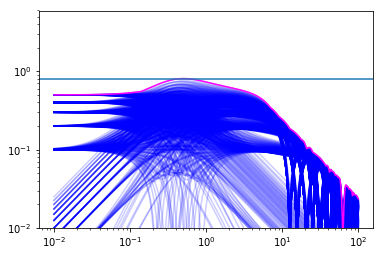

In [64]:
plt.loglog(omega, numpy.abs(deviations.T), color='blue', alpha=0.2);
plt.loglog(omega, maxima, color='magenta')
plt.axhline(radius)
#plt.loglog(pomega, radius, 'r.')
plt.ylim(ymin=1e-2)

Optimisation of the maximum
---------------------------

In [25]:
from scipy.optimize import minimize

In [65]:
def objective(x, omega):
    k, tau, theta = x
    s = 1j*omega
    return -numpy.abs(Gnom(s) - G_P(k, tau, theta, s))

In [66]:
objective([2.5, 2.5, 2.5], 0)

-0.0

In [79]:
x0 = numpy.array([2.5, 2.5, 2.5])
bounds = [[2, 3]]*3
minimize(objective, x0, args=0, bounds=bounds)

      fun: -0.5
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.99999999,  0.        ,  0.        ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
   status: 0
  success: True
        x: array([ 3. ,  2.5,  2.5])

In [82]:
vals = []
for omegai in omega:
    r = minimize(objective, 
                 x0, 
                 args=omegai, 
                 bounds=bounds)
    vals.append(-r['fun'])

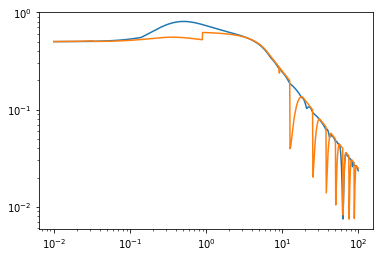

In [83]:
plt.loglog(omega, maxima)
plt.loglog(omega, vals)

In [84]:
def plot_upper(K, tau, plotmax):
    w_A = K/(tau*s + 1)
    if plotmax:
        plt.loglog(omega, maxima, color='blue')
    else:
        plt.loglog(omega, numpy.abs(deviations.T), color='blue', alpha=0.1);
    plt.loglog(omega, numpy.abs(w_A), color='red')
    plt.ylim(ymin=1e-2)

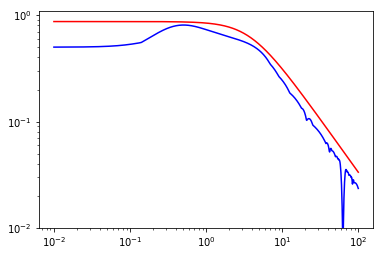

In [85]:
i = interact(plot_upper, K=(0.1, 2, 0.01), tau=(0.01, 1, 0.01), 
             plotmax=widgets.Checkbox())

In [86]:
def combined(pomega, K, tau, plotmax):
    f = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plot_upper(K, tau, plotmax)
    plt.axvline(pomega)
    plt.subplot(1, 2, 2)
    s = 1j*pomega
    radius = numpy.abs(K/(tau*s + 1))
    discapprox(pomega, radius)

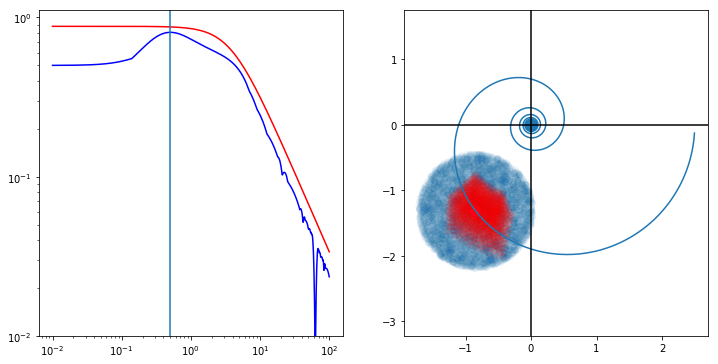

In [34]:
interact(combined, pomega=(0.1, 10), K=(0.1, 2, 0.01), tau=(0.01, 1, 0.01), 
         plotmax=widgets.Checkbox())

## Addednum: understanding the use of partial

In the code above we used the function `functools.partial`. What's going on there?

Let's say we have a function with many arguments, but we want to optimise only one:

In [1]:
def function_with_many_arguments(a, b, c, d):
    return 1*a + 2*b + 3*c + 4*d

We could define a "wrapper" which just calls that function with the single argument we need.

In [2]:
def wrapper_function(d):
    return function_with_many_arguments(1, 2, 3, d)

In [3]:
wrapper_function(2)

22

In [4]:
import scipy.optimize

In [5]:
scipy.optimize.fsolve(wrapper_function, 3)

array([-3.5])

`functools.partial` automates the creation of this wrapper function.

In [6]:
from functools import partial

In [7]:
wrapper_function = partial(function_with_many_arguments, 1, 2, 3)

In [8]:
wrapper_function(2)

22